In [1]:
import numpy as np
import collections
import basic_help

In [2]:
# !wget https://gitlab.com/jumson/sdr-samples/raw/master/garage_door_opener/gdo_2M_200k_315.218M_400k

In [3]:
my_burst = basic_help.Burst()
my_burst.name = 'old_gdo_3895e5_ook'
raw_file = './gdo_2M_200k_315.218M_400k'
my_burst.center_freq = 315.218e6
my_burst.samp_rate = 2e6
my_burst.offset = -200e3
my_burst.threshold = .01
my_burst.raw_input_file = raw_file    # 70MB"
my_burst.raw_input_file

'./gdo_2M_200k_315.218M_400k'

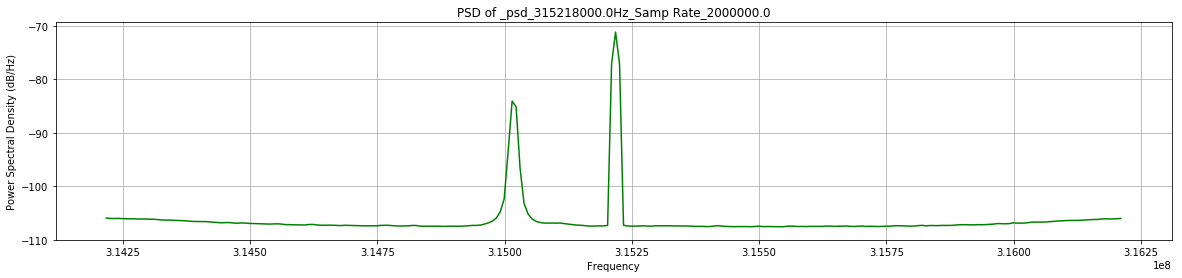

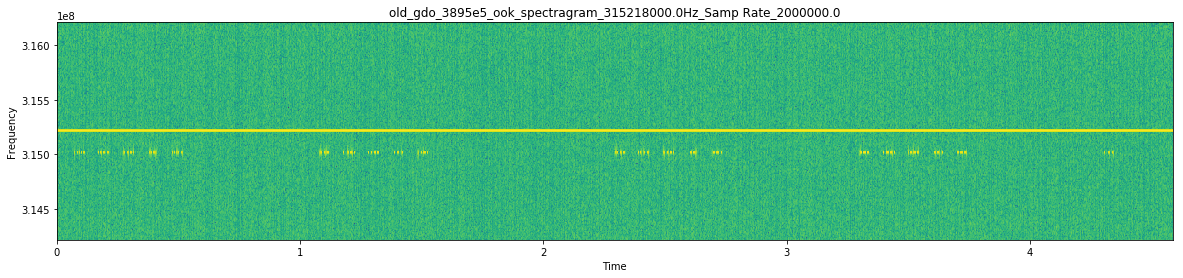

In [4]:
#my_burst.show_psd()
#my_burst.show_spec()

In [5]:
# 76MB file took 6.53 seconds, produced 4MB file
# # took 48.2 seconds for 597MB file, produced 20.6MB file

my_burst = basic_help.filter_raw(my_burst)
my_burst.raw_input_file

'./gdo_2M_200k_315.218M_400k.filtered'

In [6]:
my_burst.load_data()
#my_burst.show_psd()
#my_burst.show_spec()

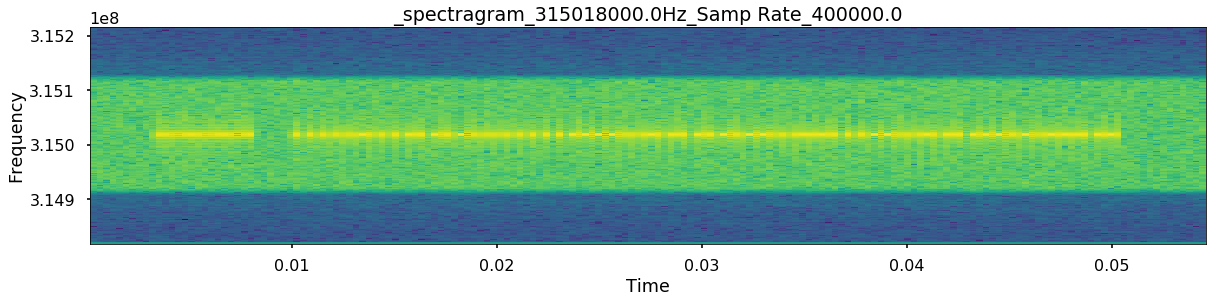

In [7]:
lefty = int(my_burst.samp_rate*.065)
righty = lefty+int(my_burst.samp_rate*.055)
#basic_help.plot_spec(my_burst.data_arr[lefty:righty],my_burst.samp_rate,my_burst.center_freq + my_burst.offset)

In [9]:
## these are calcuated by measuring the distance/time between the bursts experimentally determiend
dist_between_bursts = .03*my_burst.samp_rate

In [10]:
# the complex data is converted into magnitudes
mags = np.absolute(my_burst.data_arr)
# the threshold is automatically calculated by finding the maximum magnitude, then dividing it by two
# this assumes no "noise" was included directly in this filtered data
mythresh = np.amax(mags)/2

# numpy creates an array of positions where the magnitudes are higher than the threshold value
# this accomplishes nearly the same thing as gnuradio binary slicer, a kind of metadata though
sliced_data = np.array(np.where(mags > mythresh )[0])


#highest = np.amax(sliced_data)
# the differences between each consecutive number is calculated and placed in this new array
new = np.array(np.ediff1d(sliced_data))

# if the differences between the sliced data postions are greater than the average distance between the normal bursts,
# then the number indicates a new burst, and this array holds the starting location of each noew burst.
burst_segments = np.where(new > dist_between_bursts )[0]
burst_segments

array([  8119,  16656,  25257,  33862,  42324,  50976,  59643,  68296,
        76910,  85485,  94429, 103380, 112349, 121307, 130265, 139275,
       148281, 157248, 166185, 175114])

In [11]:
# chunk through and slice out each burst to analyze seperately
cur = 0
the_bursts = []
for nex in burst_segments:
    # print(cur,nex)
    #print(sliced_data[cur],sliced_data[nex])
    # my_burst.show_spec() .001
    the_bursts.append(np.absolute(my_burst.data_arr[sliced_data[cur]:sliced_data[nex]]))
    # shift over
    cur = nex+1

0 8119
8120 16656
16657 25257
25258 33862
33863 42324
42325 50976
50977 59643
59644 68296
68297 76910
76911 85485
85486 94429
94430 103380
103381 112349
112350 121307
121308 130265
130266 139275
139276 148281
148282 157248
157249 166185
166186 175114


In [20]:
# detect the gap between the preamble and data, using same method as above, but on single burst
# based on specgram, looks like near .001 seconds, anything smaller should be treated as gap between data symbols
gap_after_preamble = .001*my_burst.samp_rate

# the complex data is converted into magnitudes
mags = np.absolute(the_bursts[0])

# numpy creates an array of positions where the magnitudes are higher than the threshold value
# this accomplishes nearly the same thing as gnuradio binary slicer, a kind of metadata though
sliced_data = np.array(np.where(mags > mythresh )[0])


#highest = np.amax(sliced_data)
# the differences between each consecutive number is calculated and placed in this new array
new = np.array(np.ediff1d(sliced_data))

# if the differences between the sliced data postions are greater than the average distance between the normal bursts,
# then the number indicates a new burst, and this array holds the starting location of each noew burst.
preamble_loc = np.where(new > gap_after_preamble )[0]
# this slice is the preamble,
print(sliced_data[0],sliced_data[preamble_loc[0]])
#and this slice is the rest of the data
print(sliced_data[preamble_loc[0]+1],the_bursts[0].size)

0 1874
2692 18726


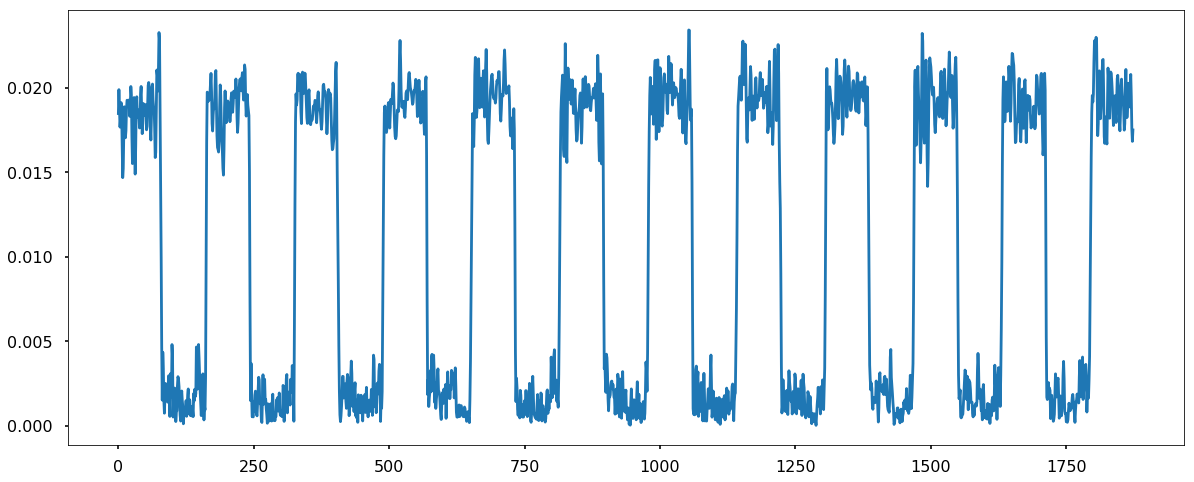

In [134]:
# looking at closeups of the preamble
# my_burst.show_spec() .001
data = np.absolute(the_bursts[0][sliced_data[0]:sliced_data[preamble_loc[0]]])
# the x axis will be each value --
lefty = 0 
righty = data.size # lefty + 300 #data.size
#x = range(len(data))
x = range(len(data[lefty:righty]))
# the y axis is dat 
plt.figure(figsize=(20,8))
#plt.scatter(x,dat[lefty:righty])
plt.plot(x,data[lefty:righty])
#plt.plot(x,data)
plt.show()

In [210]:
## now to find widths of minimum symbols --- need to have an idea of minimum sumbol length in samples
# zooming in on plot of preamble might help -- choose something like half the preamble bits
# they look about 75 samples wide so...for samp_rate of 4e5, that is 187 microseconds (.0001875 seconds)
# half that is 
min_symbol_length = int(.00008125 * my_burst.samp_rate)

# these are the magnitudes of the preamble part of the burst
the_burst_pramble = np.absolute(the_bursts[0][sliced_data[0]:sliced_data[preamble_loc[0]]])

preamble_threshold  = np.amax(the_burst_pramble)/2

#these are the locations where the magnitudes reach the threshold
preamble_bit_locs = np.array(np.where(the_burst_pramble > preamble_threshold )[0])

#because the last 1 is not counted -- making up a value to store there
# try not to let is skew the analysis
#val = np.amax(preamble_bit_locs)
#preamble_bit_locs = np.append(preamble_bit_locs,(val+(min_symbol_length*2)))

# oposite list for gaps
preamble_gap_locs = np.array(np.where(the_burst_pramble < preamble_threshold )[0])

# now where the difference between locations is only one, that is part of a consecutive bit, where it is more than one, that is a gap
# this returns an array of th edifferences in consecutive values
preamb_thresh_bit_diffs = np.diff(preamble_bit_locs)
# same for gaps
preamb_thresh_gap_diffs = np.diff(preamble_gap_locs)

# this will return an array of where those values are more than our min_symbol length
preamb_bit_locations = np.where(preamb_thresh_bit_diffs > min_symbol_length)

#now get the gaps
preamb_gap_locations = np.where(preamb_thresh_gap_diffs > min_symbol_length)
# remember that the first location is the beginning of a bit
## correcting info lost from the diffs, adding the next bit/gap locations
#  appending a value that is one more than the previous last value:
preamb_bit_locations = np.append(preamb_bit_locations,(preamb_bit_locations[0][len(preamb_bit_locations[0])-1])+1)
preamb_gap_locations = np.append(preamb_gap_locations,(preamb_gap_locations[0][len(preamb_gap_locations[0])-1])+1)

#and this shows us the "lengths" between bits
preamb_bit_lengths = np.diff(preamb_bit_locations)
preamb_gap_lengths = np.diff(preamb_gap_locations)

print("min symbol length",min_symbol_length)
print("threshold",preamble_threshold)
print("preamble bit locations",preamb_bit_locations)
print("preamble gap locations",preamb_gap_locations)
print("preamble bit symbol lengths",preamb_bit_lengths)
print("preamble gap symbol lengths",preamb_gap_lengths)
#print("bit locs:",preamble_bit_locs)
#print("gap locs:",preamble_gap_locs)
np.where(np.diff(preamble_bit_locs,n=2) > 0) 

min symbol length 32
threshold 0.0117120789364
preamble bit locations [ 78 158 238 319 400 480 561 641 721 802 883 884]
preamble gap locations [ 83 166 249 331 414 497 580 663 746 828 829]
preamble bit symbol lengths [80 80 81 81 80 81 80 80 81 81  1]
preamble gap symbol lengths [83 83 82 83 83 83 83 83 82  1]


(array([ 77, 157, 237, 318, 399, 479, 560, 640, 720, 801, 882]),)

In [203]:
preamble_gap_locs[829]

1713

In [211]:
# now combine the lists of locations of gaps and bits, and put them in order
symbol_locs = np.array([])
bit_list = []
gap_list = []

for locs in preamb_bit_locations:
    val = preamble_bit_locs[locs]
    symbol_locs = np.append(symbol_locs,val)
    bit_list.append(val)
    
for locs in preamb_gap_locations:
    val = preamble_gap_locs[locs]
    symbol_locs = np.append(symbol_locs,val)
    gap_list.append(val)

symbol_list = np.sort(symbol_locs)
print(symbol_list)
# presumt the sumbols start with a 1?
symbol_vals = []
# iterate through the_burst_base, testing the lengths/values of the symbols and assigning symbols
for pos in symbol_list:
    test = np.isin(bit_list,pos)
    if len(np.where(test == True)[0]):
        symbol_vals.append(1)
    test = np.isin(gap_list,pos)
    if len(np.where(test == True)[0]):
        symbol_vals.append(0)

print(symbol_vals)

[   78.   162.   242.   325.   405.   488.   569.   651.   732.   815.
   895.   978.  1059.  1142.  1222.  1305.  1385.  1468.  1549.  1631.
  1712.  1713.  1795.]
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]


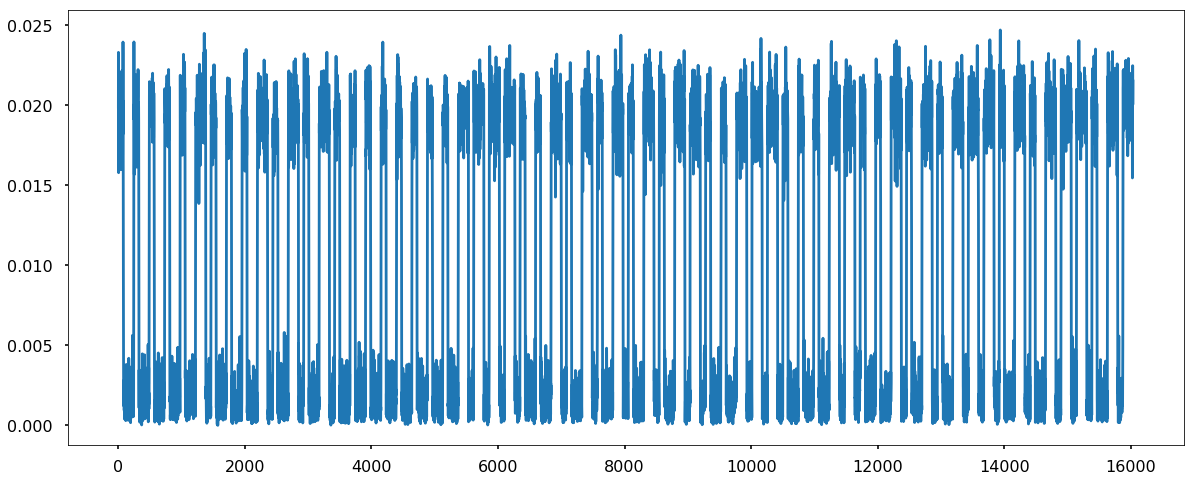

In [217]:
# looking at closeups of the base of the burst

# my_burst.show_spec() .001 sliced_data[preamble_loc[0]+1],the_bursts[0].size
data = np.absolute(the_bursts[0][sliced_data[preamble_loc[0]+1]:the_bursts[0].size])
# the x axis will be each value --
lefty = 0
righty = data.size#lefty + 2000
#x = range(len(data))
x = range(len(data[lefty:righty]))
# the y axis is dat 
plt.figure(figsize=(20,8))
#plt.scatter(x,dat[lefty:righty])
plt.plot(x,data[lefty:righty])
#plt.plot(x,data)
plt.show()

In [212]:
#now to evaluate the remainder of a burst
# copying the methodology from above for the preamble

min_symbol_length = int(.00008125 * my_burst.samp_rate)

# these are the magnitudes of the preamble part of the burst
the_burst_base = np.absolute(the_bursts[0][sliced_data[preamble_loc[0]+1]:the_bursts[0].size])

base_threshold  = np.amax(the_burst_base)/2

#these are the locations where the magnitudes reach the threshold
base_bit_locs = np.array(np.where(the_burst_base > base_threshold )[0])
# oposite list for gaps
base_gap_locs = np.array(np.where(the_burst_base < base_threshold )[0])

# now where the difference between locations is only one, that is part of a consecutive bit, where it is more than one, that is a gap
# this returns an array of th edifferences in consecutive values
base_thresh_bit_diffs = np.diff(base_bit_locs)
print("base_thresh_bit_diffs",base_thresh_bit_diffs)

# same for gaps
base_thresh_gap_diffs = np.diff(base_gap_locs)
#   base_bit_locs[base_thresh_gap_diffs[base_bit_locations]] == location in the burst base
# this will return an array of where those values are more than our min_symbol length
base_bit_locations = np.where(base_thresh_bit_diffs > min_symbol_length)
#now get the gaps
base_gap_locations = np.where(base_thresh_gap_diffs > min_symbol_length)
# remember that the first location is the beginning of a bit

## correcting info lost from the diffs, adding the next bit/gap locations
#  appending a value that is one more than the previous last value:
base_bit_locations = np.append(base_bit_locations,(base_bit_locations[0][len(base_bit_locations[0])-1])+1)
base_gap_locations = np.append(base_gap_locations,(base_gap_locations[0][len(base_gap_locations[0])-1])+1)



#and this shows us the "lengths" between bits
base_bit_lengths = np.diff(base_bit_locations)
base_gap_lengths = np.diff(base_gap_locations)

print("min symbol length",min_symbol_length)
print("threshold",base_threshold)
print("base bit locations",base_bit_locations)
print("base gap locations",base_gap_locations)
print("base bit symbol lengths",base_bit_lengths)
print("base gap symbol lengths",base_gap_lengths)

base_thresh_bit_diffs [1 1 1 ..., 1 1 1]
min symbol length 32
threshold 0.0123570971191
base bit locations [  78  158  238  319  398  558  638  718  798  959 1040 1200 1280 1442 1522
 1602 1682 1763 1843 1923 2002 2082 2243 2403 2564 2725 2805 2885 3046 3127
 3288 3368 3529 3609 3769 3849 4009 4170 4250 4330 4491 4652 4813 4892 4973
 5054 5214 5375 5455 5535 5696 5776 5937 6017 6178 6339 6501 6581 6742 6822
 6983 7143 7304 7384 7544 7545]
base gap locations [ 163  327  491  655  820  904 1068 1233 1397 1480 1644 1727 1891 1974 2138
 2303 2467 2630 2794 2959 3124 3288 3371 3456 3539 3622 3786 3950 4033 4197
 4280 4445 4528 4692 4776 4941 5024 5108 5272 5437 5520 5603 5687 5851 6014
 6178 6262 6346 6510 6674 6757 6921 7005 7169 7252 7336 7418 7582 7665 7829
 7913 7997 8080 8245 8246]
base bit symbol lengths [ 80  80  81  79 160  80  80  80 161  81 160  80 162  80  80  80  81  80
  80  79  80 161 160 161 161  80  80 161  81 161  80 161  80 160  80 160
 161  80  80 161 161 161  79  81  81 

(array([  77,  157,  237,  318,  397,  557,  637,  717,  797,  958, 1039,
        1199, 1279, 1441, 1521, 1601, 1681, 1762, 1842, 1922, 2001, 2081,
        2242, 2402, 2563, 2724, 2804, 2884, 3045, 3126, 3287, 3367, 3528,
        3608, 3768, 3848, 4008, 4169, 4249, 4329, 4490, 4651, 4812, 4891,
        4972, 5053, 5213, 5374, 5454, 5534, 5695, 5775, 5936, 6016, 6177,
        6338, 6500, 6580, 6741, 6821, 6982, 7142, 7303, 7383, 7543]),)

In [213]:
# all the bitwidths look very normal -- 
# can now populate threshold values for bits - to determine when assigning 11 vs 1
ones_threshold = np.average(base_bit_lengths)
zeros_threshold = np.average(base_gap_lengths)

print("ones threshold",ones_threshold)
print("zeros threshold",zeros_threshold)

ones threshold 114.876923077
zeros threshold 126.296875


In [214]:
# now combine the lists of locations of gaps and bits, and put them in order
symbol_locs = np.array([])
bit_list = []
gap_list = []

for locs in base_bit_locations:
    val = base_bit_locs[locs]
    symbol_locs = np.append(symbol_locs,val)
    bit_list.append(val)
    
for locs in base_gap_locations:
    val = base_gap_locs[locs]
    symbol_locs = np.append(symbol_locs,val)
    gap_list.append(val)

symbol_list = np.sort(symbol_locs)
print(symbol_list)
# presumt the sumbols start with a 1?
symbol_vals = []
prev = 0
# iterate through the_burst_base, testing the lengths/values of the symbols and assigning symbols
for pos in symbol_list:
    test = np.isin(bit_list,pos)
    if len(np.where(test == True)[0]):
        if pos-prev > ones_threshold:
            symbol_vals.append(1)
            symbol_vals.append(1)
        else:
            symbol_vals.append(1)
        prev = pos
        continue
    test = np.isin(gap_list,pos)
    if len(np.where(test == True)[0]):
        if pos-prev > zeros_threshold:
            symbol_vals.append(0)
            symbol_vals.append(0)
        else:
            symbol_vals.append(0)
        prev = pos
print(symbol_vals)

[    78.    242.    322.    486.    566.    730.    811.    975.   1054.
   1219.   1379.   1463.   1543.   1707.   1787.   1952.   2032.   2196.
   2357.   2440.   2521.   2685.   2845.   2928.   3008.   3172.   3334.
   3417.   3497.   3661.   3741.   3906.   3986.   4150.   4231.   4394.
   4474.   4638.   4718.   4883.   4962.   5127.   5207.   5371.   5532.
   5615.   5775.   5860.   6021.   6104.   6265.   6348.   6428.   6592.
   6672.   6836.   6997.   7080.   7161.   7325.   7486.   7569.   7649.
   7814.   7975.   8058.   8138.   8302.   8462.   8546.   8626.   8791.
   8951.   9034.   9195.   9279.   9359.   9523.   9603.   9768.   9929.
  10012.  10173.  10256.  10417.  10501.  10580.  10744.  10825.  10988.
  11069.  11233.  11393.  11477.  11638.  11722.  11802.  11966.  12046.
  12210.  12371.  12454.  12534.  12698.  12859.  12943.  13023.  13187.
  13348.  13431.  13592.  13676.  13838.  13920.  14000.  14164.  14325.
  14408.  14488.  14652.  14813.  14897.  15057.  1

In [128]:
# still appearing to lose a bit on the end....perhaps just add it?
#  symbol_vals = symbol_vals + [1]
#[    78.    242.    322.    486.    566.    730.    811.    975.   1054.1219.   1379.   1463.   1543.   1707.   1787.   1952.   2032.   2196.2357.   2440.   2521.   2685.   2845.   2928.   3008.   3172.   3334.3417.   3497.   3661.   3741.   3906.   3986.   4150.   4231.   4394.4474.   4638.   4718.   4883.   4962.   5127.   5207.   5371.   5532.5615.   5775.   5860.   6021.   6104.   6265.   6348.   6428.   6592.    6672.   6836.   6997.   7080.   7161.   7325.   7486.   7569.   7649.7814.   7975.   8058.   8138.   8302.   8462.   8546.   8626.   8791. 8951.   9034.   9195.   9279.   9359.   9523.   9603.   9768.   9929.   10012.  10173.  10256.  10417.  10501.  10580.  10744.  10825.  10988.11069.  11233.  11393.  11477.  11638.  11722.  11802.  11966.  12046. 12210.  12371.  12454.  12534.  12698.  12859.  12943.  13023.  13187. 13348.  13431.  13592.  13676.  13838.  13920.  14000.  14164.  14325. 14408.  14488.  14652.  14813.  14897.  15057.  15141.  15302.  15385. 15465.  15630.  15790.]
# [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1]

80

In [216]:
symbol_vals = symbol_vals + [1]